# Metadata mapping and generation for spatial transcriptomic datasets

This notebooks contains code for mapping metadata to some of the spatial transcriptomics datasets and generating novel metadata for some of the spatial transcriptomics datasets.

The notebook requires having the dataset folders formatted and in "DataUpload" top-level directory in the current working directory. The data can be retrieved from the Zenodo repository in our manuscript (DOI: 10.5281/zenodo.8259942).

For some datasets, this notebook also requires downloading metadata or AnnData objects from the respective publications that they were originally published with.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from TISSUE.tissue.main import *

### Axolotl Stereo-seq

In [ ]:
# Axolotl spatial data processing -- download "Stage44.h5ad" from source data

data_dirpath = "DataUpload/Axolotl"
adata = sc.read_h5ad(os.path.join(data_dirpath,"Stage44.h5ad"))

# swap to genes for varnames
adata.var['Full'] = adata.var_names
adata.var_names = adata.var['Gene']

In [ ]:
locations = pd.DataFrame(adata.obsm['spatial'], columns=['x','y'])
locations.to_csv(os.path.join(data_dirpath,"Locations.txt"), sep="\t", index=False)

In [ ]:
df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

In [ ]:
df.to_csv(os.path.join(data_dirpath,"Spatial_count.txt"), sep="\t", index=False)

In [ ]:
meta = pd.DataFrame(adata.obs)
meta

In [ ]:
meta.to_csv(os.path.join(data_dirpath,"Metadata.txt"))

### Dataset 3: Mouse hippocampus

In [55]:
dataset_name = "Dataset3"

adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                         "DataUpload/"+dataset_name+"/Locations.txt")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [56]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=0.3) # 1.401 for 18 clusters
sc.tl.umap(adata)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


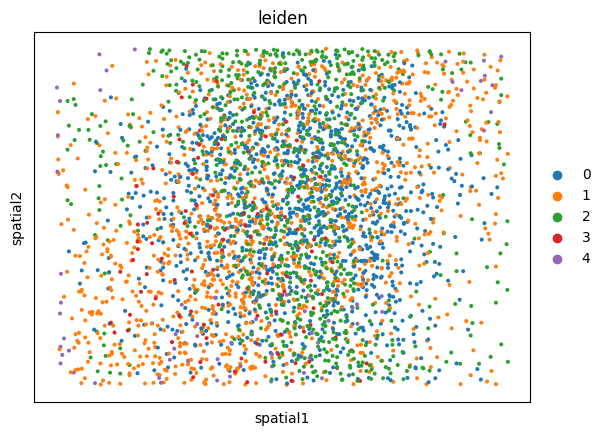

In [57]:
sc.pl.embedding(adata, "spatial", color="leiden")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value enco

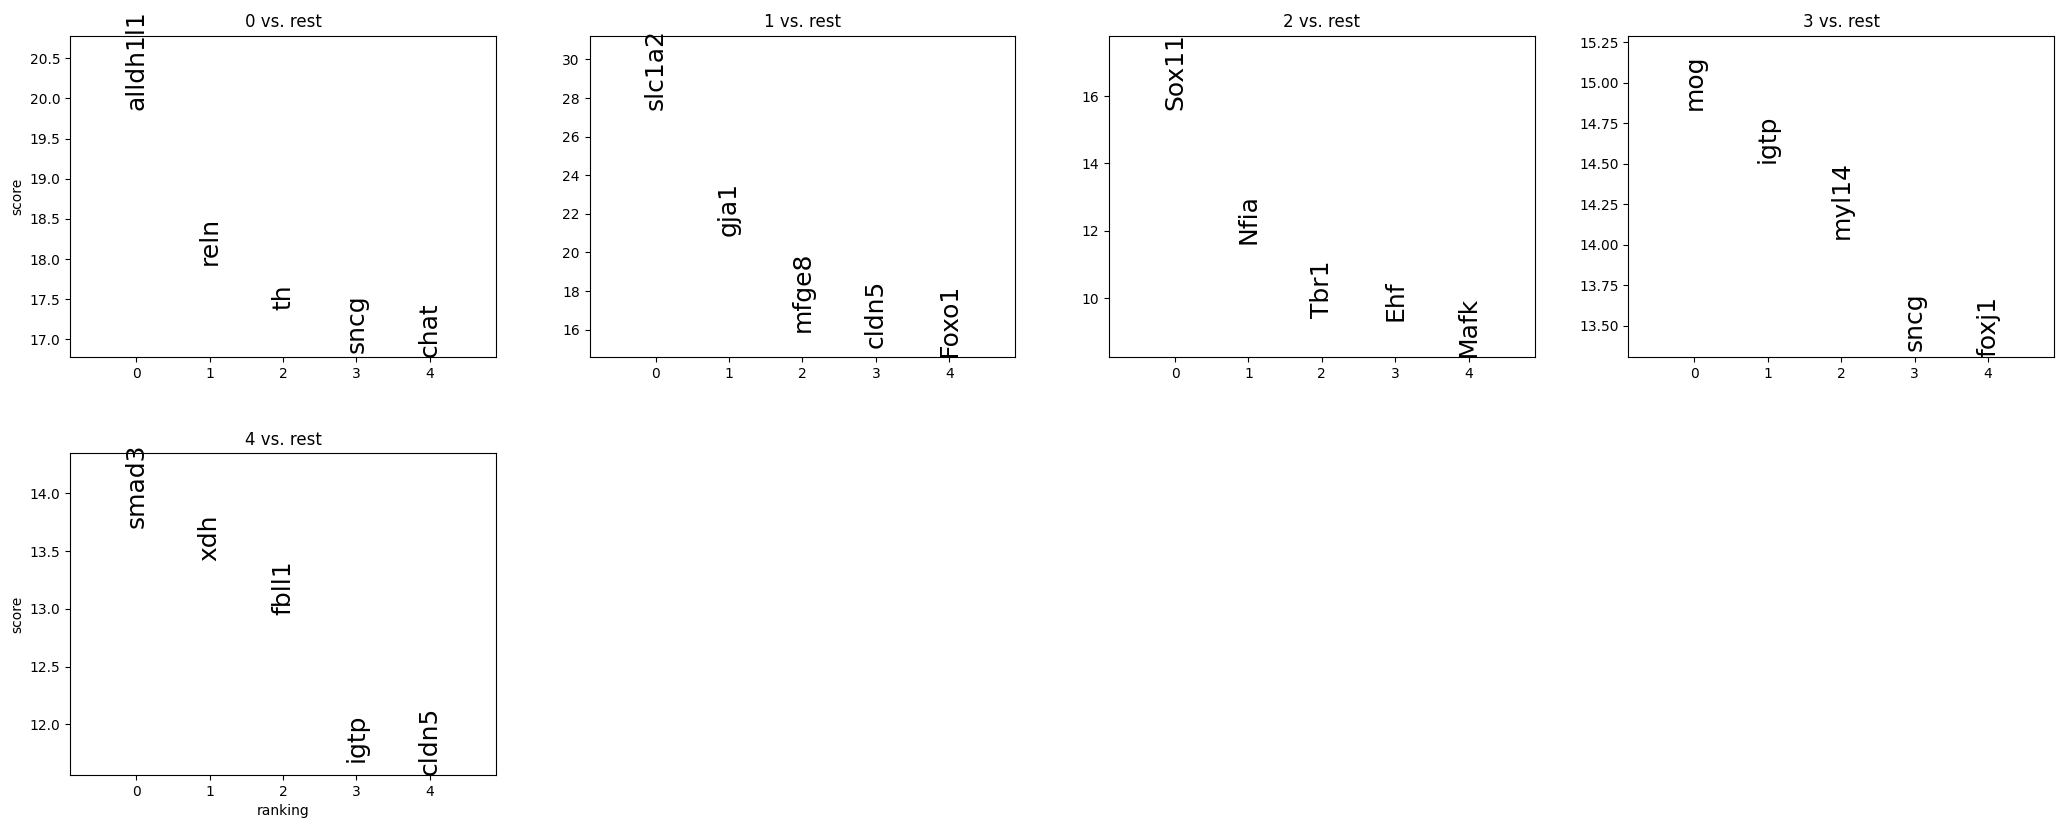

In [58]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False, ncols=4, fontsize=18)

#### Clusters identified using PanglaoDB for top 5 marker genes (with "Species=Mouse") July 17, 2023

In [60]:
for i in range(5):
    print(i)
    genes = []
    for j in range(5):
        genes.append(list(adata.uns['rank_genes_groups']['names'][j])[i].lower())
    print(",".join(genes))

0
alldh1l1,reln,th,sncg,chat
1
slc1a2,gja1,mfge8,cldn5,foxo1
2
sox11,nfia,tbr1,ehf,mafk
3
mog,igtp,myl14,sncg,foxj1
4
smad3,xdh,fbll1,igtp,cldn5


In [62]:
cluster_mapper = {"0": "Neuron 1",
                  "1": "Astrocyte",
                  "2": "Neuron 2",
                  "3": "Oligodendrocyte",
                  "4": "Endothelial cell"}

adata.obs["celltype"] = adata.obs["leiden"].map(cluster_mapper)

In [63]:
metadata = adata.obs
metadata.to_csv("DataUpload/"+dataset_name+"/Metadata.txt")

### Dataset 14: Drosophila embryo

https://www.science.org/doi/10.1126/science.aan3235

In [2]:
dataset_name = "Dataset14"

adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                         "DataUpload/"+dataset_name+"/Locations.txt")

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:63: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  spatial_adata = ad.AnnData(X=df)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [3]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


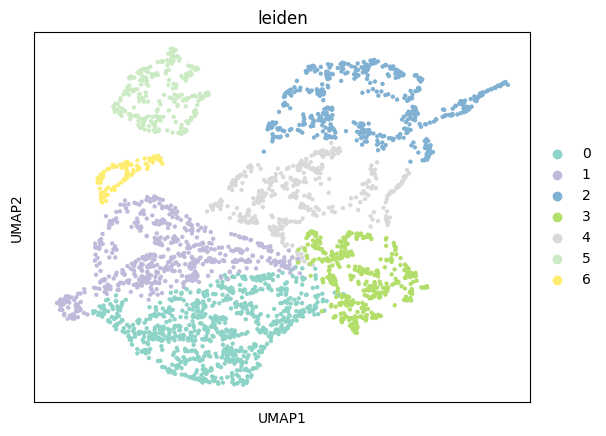

In [4]:
sc.pl.embedding(adata, "umap", color="leiden", palette="tab10")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


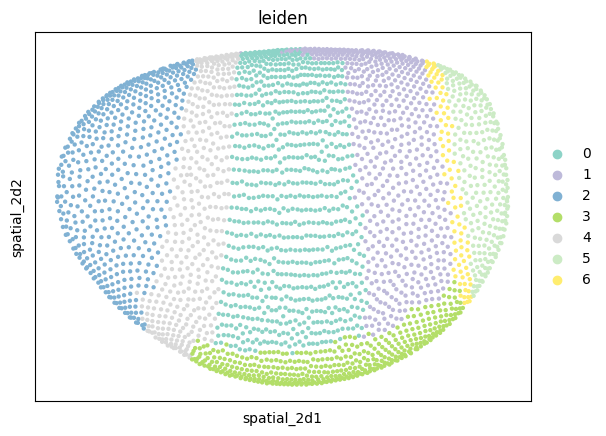

In [5]:
adata.obsm["spatial_2d"] = adata.obsm["spatial"][:,np.array([0,2])]
sc.pl.embedding(adata, "spatial_2d", color="leiden", palette="tab10")

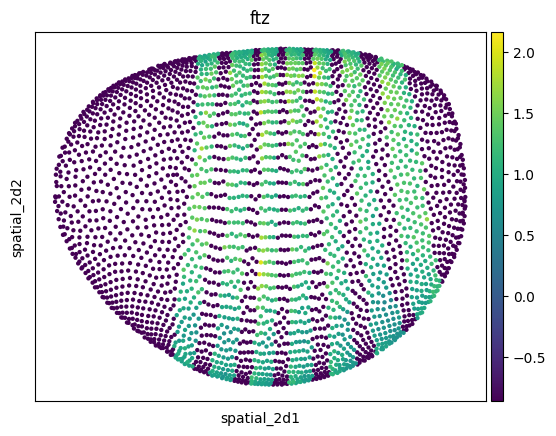

In [53]:
adata.obsm["spatial_2d"] = adata.obsm["spatial"][:,np.array([0,2])]
sc.pl.embedding(adata, "spatial_2d", color="ftz")

Metadata annotation:
- Based on ftz expression which is focused on mid-posterior regions of embryo
- Four groups: "anterior", "middle", "posterior", "bottom" based on the lateral view above

In [54]:
adata.obs["region"] = adata.obs["leiden"].map({"2":"anterior",
                                               "5":"posterior",
                                               "3":"bottom",
                                               "0":"middle",
                                               "1":"middle",
                                               "4":"middle",
                                               "6":"posterior"})

adata.obs['region'] = adata.obs['region'].astype('category')

In [55]:
metadata = adata.obs
metadata.to_csv("DataUpload/"+dataset_name+"/Metadata.txt")

### Dataset 11: STARmap prefrontal cortex mouse

Dataset URL is not loading... https://www.starmapresources.com/data

### Dataset 15: osmFISH mouse somatosensory cortex

In [30]:
adata_full = sc.read_loom("DataUpload/Dataset15/osmFISH_SScortex_mouse_all_cells.loom")

adata_full

AnnData object with n_obs × n_vars = 6471 × 33
    obs: 'ClusterID', 'ClusterName', 'Region', 'Total_molecules', 'Valid', 'X', 'Y', '_tSNE_1', '_tSNE_2', 'size_pix', 'size_um2'
    var: 'Fluorophore', 'Hybridization'

In [31]:
Cortex_Regions = ['Layer 2-3 lateral', 'Layer 2-3 medial', 'Layer 3-4', 
                  'Layer 4','Layer 5', 'Layer 6', 'Pia Layer 1']

adata_full = adata_full[adata_full.obs["Region"].isin(Cortex_Regions)]

In [32]:
adata_full

View of AnnData object with n_obs × n_vars = 3405 × 33
    obs: 'ClusterID', 'ClusterName', 'Region', 'Total_molecules', 'Valid', 'X', 'Y', '_tSNE_1', '_tSNE_2', 'size_pix', 'size_um2'
    var: 'Fluorophore', 'Hybridization'

In [33]:
dataset_name = "Dataset15"

adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                         "DataUpload/"+dataset_name+"/Locations.txt")

adata

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:63: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  spatial_adata = ad.AnnData(X=df)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


AnnData object with n_obs × n_vars = 3405 × 33
    obsm: 'spatial'

In [34]:
adata_full.X.toarray()

array([[ 35.,  41.,   0., ...,   0.,   4.,   3.],
       [ 95.,  49.,   5., ...,   0.,   4.,   1.],
       [111.,  92.,  24., ...,   0.,   2.,   3.],
       ...,
       [  5.,   2.,   0., ...,   0.,   5.,  29.],
       [  2.,   0.,   0., ...,   0.,   2.,   5.],
       [  5.,   0.,   0., ...,   0.,   0.,  15.]], dtype=float32)

In [35]:
adata.X

array([[ 35.,  41.,   0., ...,   0.,   4.,   3.],
       [ 95.,  49.,   5., ...,   0.,   4.,   1.],
       [111.,  92.,  24., ...,   0.,   2.,   3.],
       ...,
       [  5.,   2.,   0., ...,   0.,   5.,  29.],
       [  2.,   0.,   0., ...,   0.,   2.,   5.],
       [  5.,   0.,   0., ...,   0.,   0.,  15.]], dtype=float32)

In [36]:
adata.obs = adata_full.obs.copy()
adata

AnnData object with n_obs × n_vars = 3405 × 33
    obs: 'ClusterID', 'ClusterName', 'Region', 'Total_molecules', 'Valid', 'X', 'Y', '_tSNE_1', '_tSNE_2', 'size_pix', 'size_um2'
    obsm: 'spatial'

In [37]:
adata.obs['ClusterName'] = adata.obs['ClusterName'].astype('category')
adata.obs['Region'] = adata.obs['Region'].astype('category')

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


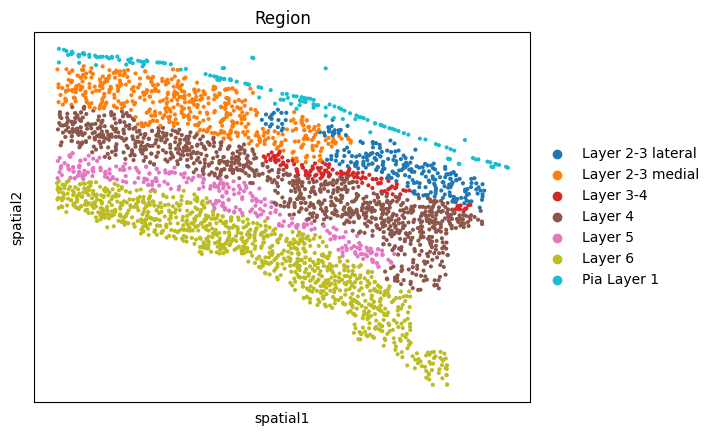

In [38]:
sc.pl.embedding(adata, "spatial", color="Region", show=False, palette="tab10")
plt.savefig("plots/scpi_datasets/dataset15_clusters.png", dpi=300, bbox_inches="tight")

In [39]:
pd.DataFrame(np.array([1,45,76,1,2])[None,:], columns=["a","b","gg","q", 'll'])

,a,b,gg,q,ll
0,1,45,76,1,2


In [16]:
metadata = adata.obs
metadata.to_csv("DataUpload/"+dataset_name+"/Metadata.txt")

### Dataset 17: ExSeq Mouse VISP

No metadata available (data associated with a competition)

https://github.com/spacetx-spacejam/data

### Dataset 9: MERFISH Mouse VISP

No metadata: https://github.com/spacetx-spacejam/data/

### Dataset 12: ISS Human MTG 

No metadata: https://github.com/spacetx-spacejam/data/

### Dataset 13: Mouse VISP

No metadata: https://github.com/spacetx-spacejam/data/

But the anatomy is quite clear from the image -- can cluster and annotate manually

In [3]:
dataset_name = "Dataset13"

adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                         "DataUpload/"+dataset_name+"/Locations.txt")

adata

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:63: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  spatial_adata = ad.AnnData(X=df)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


AnnData object with n_obs × n_vars = 6000 × 119
    obsm: 'spatial'

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


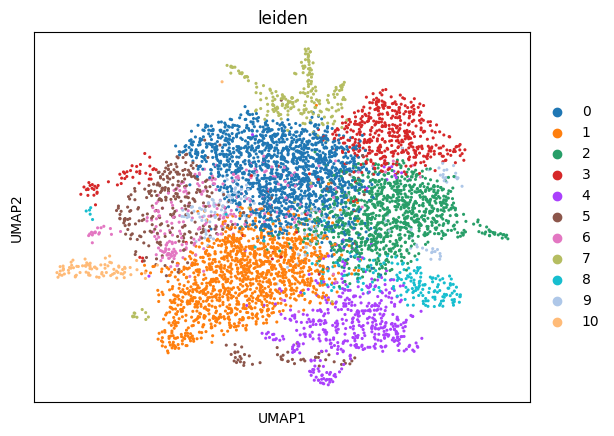

In [5]:
sc.pl.embedding(adata, "umap", color="leiden")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


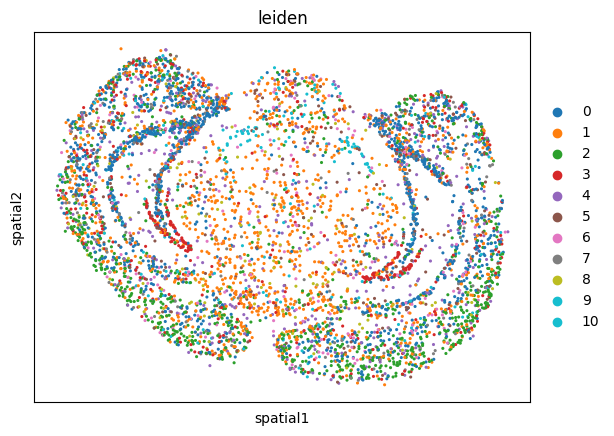

In [29]:
sc.pl.embedding(adata, "spatial", color="leiden", palette="tab10")

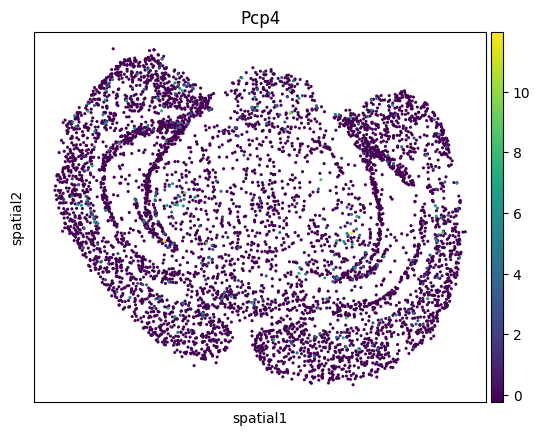

In [7]:
sc.pl.embedding(adata, "spatial", color="Pcp4", palette="tab10")

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value enco

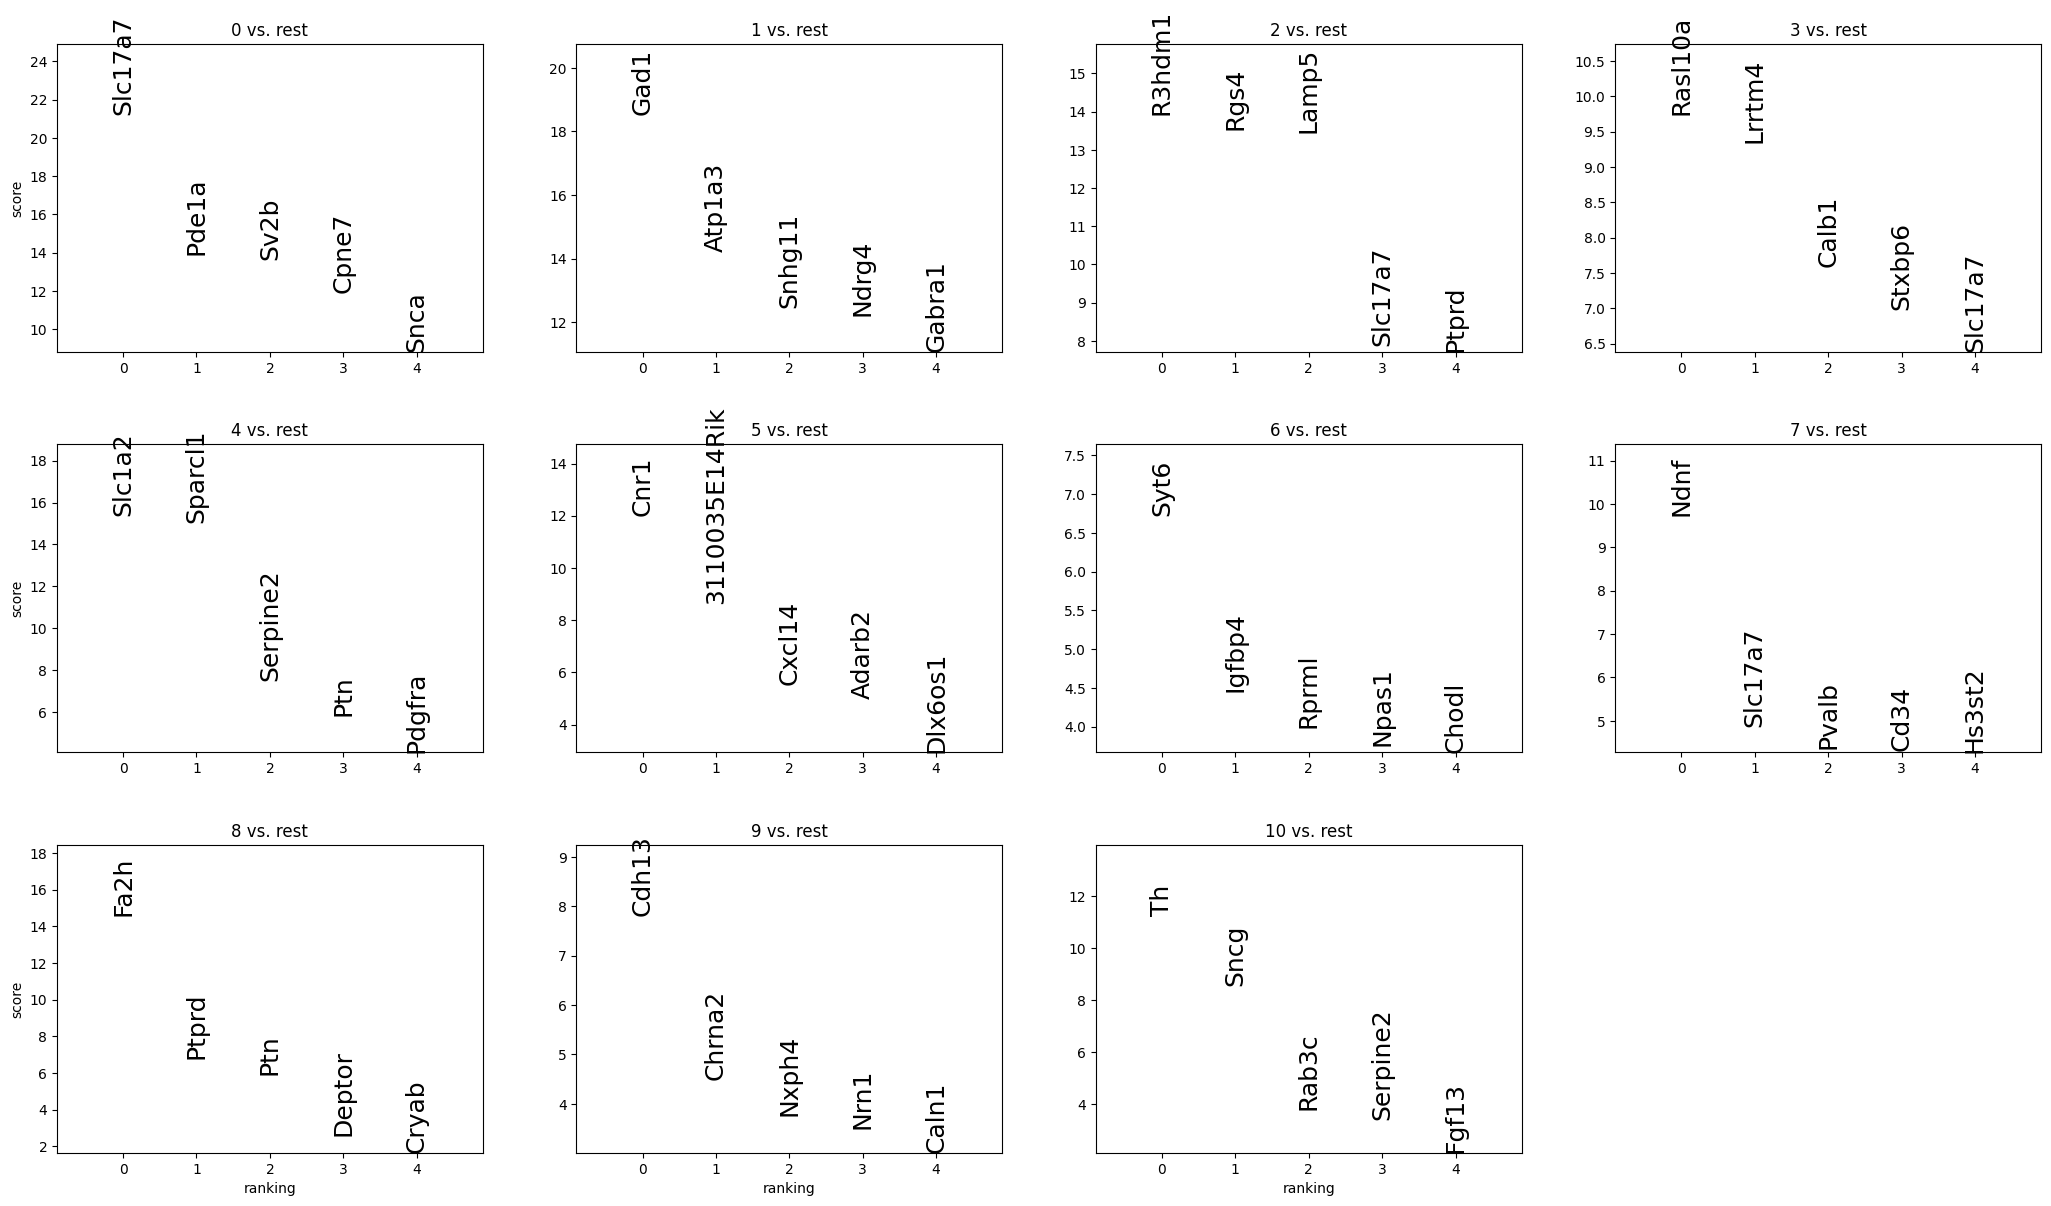

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False, ncols=4, fontsize=18)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


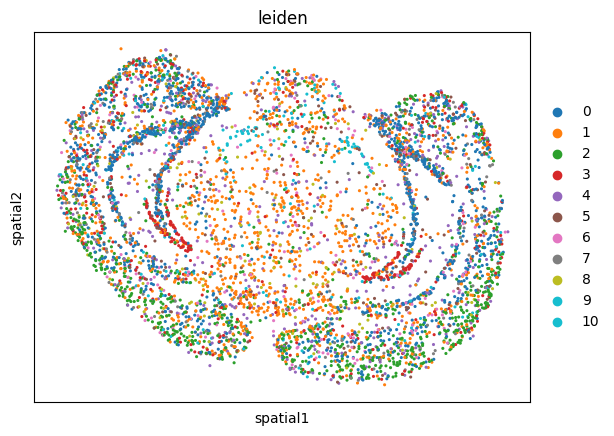

In [28]:
sc.pl.embedding(adata, "spatial", color="leiden", show=False, palette="tab10")
plt.savefig("plots/scpi_datasets/dataset13_clusters.png", dpi=300, bbox_inches="tight")

#### Clusters identified using PanglaoDB for top 5 marker genes (with "Species=Mouse") Jan 20, 2023

In [26]:
for i in range(11):
    print(i)
    genes = []
    for j in range(5):
        genes.append(list(adata.uns['rank_genes_groups']['names'][j])[i].lower())
    print(",".join(genes))

0
slc17a7,pde1a,sv2b,cpne7,snca
1
gad1,atp1a3,snhg11,ndrg4,gabra1
2
r3hdm1,rgs4,lamp5,slc17a7,ptprd
3
rasl10a,lrrtm4,calb1,stxbp6,slc17a7
4
slc1a2,sparcl1,serpine2,ptn,pdgfra
5
cnr1,3110035e14rik,cxcl14,adarb2,dlx6os1
6
syt6,igfbp4,rprml,npas1,chodl
7
ndnf,slc17a7,pvalb,cd34,hs3st2
8
fa2h,ptprd,ptn,deptor,cryab
9
cdh13,chrna2,nxph4,nrn1,caln1
10
th,sncg,rab3c,serpine2,fgf13


In [27]:
cluster_mapper = {"0": "Neuron_Slc17a7_Excitatory",
                  "1": "Neuron_Gad1_Inhibitory",
                  "2": "Neuron_R3hdm1_Interneuron",
                  "3": "Neuron_Rasl10a",
                  "4": "Astrocyte_Slc1a2",
                  "5": "Neuron_Cnr1",
                  "6": "Endothelial_Syt6",
                  "7": "Neuron_Ndnf",
                  "8": "Oligodendrocyte_Fa2h",
                  "9": "Neuron_Cdh13",
                  "10": "Neuron_Th_Dopaminergic"}

adata.obs["celltype"] = adata.obs["leiden"].map(cluster_mapper)
adata.obs["celltype_lowres"] = np.array([x.split("_")[0] for x in adata.obs["celltype"]])

In [28]:
np.unique(adata.obs["celltype"])

array(['Astrocyte_Slc1a2', 'Endothelial_Syt6', 'Neuron_Cdh13',
       'Neuron_Cnr1', 'Neuron_Gad1_Inhibitory', 'Neuron_Ndnf',
       'Neuron_R3hdm1_Interneuron', 'Neuron_Rasl10a',
       'Neuron_Slc17a7_Excitatory', 'Neuron_Th_Dopaminergic',
       'Oligodendrocyte_Fa2h'], dtype=object)

In [29]:
np.unique(adata.obs["celltype_lowres"])

array(['Astrocyte', 'Endothelial', 'Neuron', 'Oligodendrocyte'],
      dtype=object)

In [30]:
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].astype('category')
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

In [31]:
metadata = adata.obs
metadata.to_csv("DataUpload/"+dataset_name+"/Metadata.txt")

In [32]:
pd.read_csv("DataUpload/"+dataset_name+"/Metadata.txt")

,Unnamed: 0,leiden,celltype,celltype_lowres
0,0,0,Neuron_Slc17a7_Excitatory,Neuron
1,1,2,Neuron_R3hdm1_Interneuron,Neuron
2,2,0,Neuron_Slc17a7_Excitatory,Neuron
3,3,2,Neuron_R3hdm1_Interneuron,Neuron
4,4,4,Astrocyte_Slc1a2,Astrocyte
...,...,...,...,...
5995,5995,2,Neuron_R3hdm1_Interneuron,Neuron
5996,5996,1,Neuron_Gad1_Inhibitory,Neuron
5997,5997,0,Neuron_Slc17a7_Excitatory,Neuron
5998,5998,2,Neuron_R3hdm1_Interneuron,Neuron


In [33]:
dataset_name = "Dataset14"
adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                                  "DataUpload/"+dataset_name+"/Locations.txt",
                                   spatial_metadata = "DataUpload/"+dataset_name+"/Metadata.txt")

/mnt/c/Users/Eric Sun/Desktop/RESEARCH/GeneImputation/main.py:63: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  spatial_adata = ad.AnnData(X=df)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [57]:
np.unique(adata.obs['region'])

array(['anterior', 'bottom', 'middle', 'posterior'], dtype=object)

### Creating osmFISH somatosensory cortex data subset for testing/tutorial

In [ ]:
# Subsample scRNA
dataset_name = "Dataset15"
df = pd.read_csv("DataUpload/"+dataset_name+"/scRNA_count.txt",header=0,index_col=0,sep="\t")
df.shape

In [ ]:
# subset to only genes also present in spatial data
sp_df = pd.read_csv("DataUpload/"+dataset_name+"/spatial_count.txt",header=0,sep="\t")
genes = list(sp_df.columns)
df = df.loc[genes]

In [ ]:
# subsample 1000 cells
np.random.seed(444)
random_sample = np.random.choice(np.arange(df.shape[1]), 1000, replace=False)

In [ ]:
df = df.iloc[:,random_sample]
df.to_csv("TISSUE/tests/data/scRNA_count.txt",sep="\t")

In [ ]:
df = pd.read_csv("TISSUE/tests/data/scRNA_count.txt",header=0,index_col=0,sep="\t")